In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import fitsio
import numpy             as np
import pylab             as pl
import matplotlib.pyplot as plt
import astropy.io.fits   as fits

In [3]:
sys.path.append('{}'.format(os.environ['HOME']))
sys.path.append('{}/DESI'.format(os.environ['HOME']))

In [4]:
import pubplot

from schechter     import schechter, named_schechter, schechter_d8
from gama_limits   import gama_field
from delta8_limits import d8_limits, delta8_tier, d8_plot_idx
from findfile      import findfile, fetch_fields, fetch_header
from lumfn         import multifield_lumfn
from astropy.table import Table
from ddp           import tmr_DDP1

In [5]:
version = 'GAMA4'
survey  = 'gama'
field   = 'G12'
dryrun  = False

In [6]:
fields  = fetch_fields(survey)

In [7]:
# TODO: clean up root below in LF cells
root    = '{}/data/GAMA4/'.format(os.environ['HOME'])
fpath   =  findfile(ftype='ddp_n8', version=version, dryrun=dryrun, survey=survey)
fpath

'/cosma/home/durham/dc-wils7/data/GAMA4/gama_gold_ddp_n8.fits'

In [8]:
fpath   = findfile(ftype='randoms_bd_ddp_n8', field=field, version=version, dryrun=dryrun, survey=survey)
randoms = Table.read(fpath)

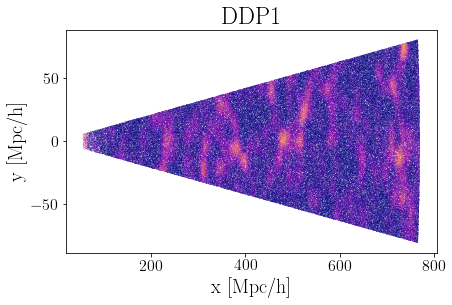

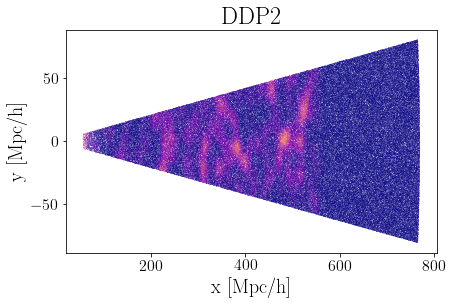

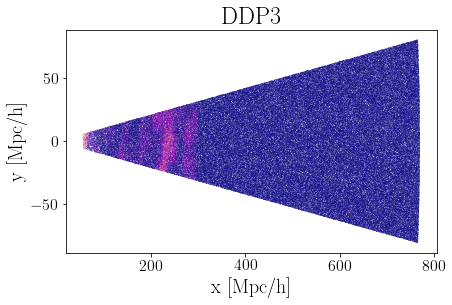

In [9]:
randoms_slice = randoms[np.abs(randoms['ROTCARTESIAN_Z']) < 5.]

for idx in np.arange(1, 4, 1):
    plt.scatter(randoms_slice['ROTCARTESIAN_X'],\
                randoms_slice['ROTCARTESIAN_Y'],\
                c=randoms_slice['DDP{}_DELTA8'.format(idx)],\
                marker='.',\
                lw=0.0,\
                s=1,\
                vmin=-1.,\
                vmax=10.,\
                cmap='plasma')

    pl.xlabel('x [Mpc/h]')
    pl.ylabel('y [Mpc/h]')
    
    plt.title('DDP{}'.format(idx))
    plt.show()

/cosma/home/durham/dc-wils7/DESI/schechter.py:19: RuntimeWarning: divide by zero encountered in log10
  Mstar         = -20.70 - 0.67 * np.log10(1. + d8)
/cosma/home/durham/dc-wils7/DESI/schechter.py:20: RuntimeWarning: divide by zero encountered in log10
  log10phistar  = -2.030 + 1.01 * np.log10(1. + d8)
/cosma/home/durham/dc-wils7/DESI/schechter.py:32: RuntimeWarning: divide by zero encountered in log10
  return  np.log10(1. + d8), log10phistar, Mstar, alpha


(-3.5, -0.5)

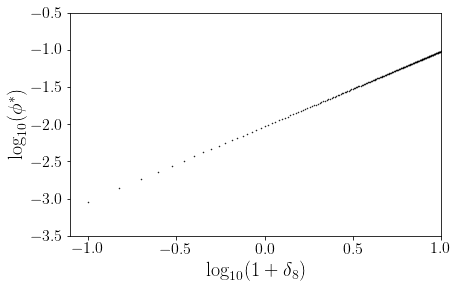

In [10]:
for d8 in np.arange(-1., 20., 0.05):
    dd, log10phistar, Mstar, alpha = schechter_d8(None, d8, params=True)
    pl.plot(dd, log10phistar, marker='.', lw=0.0, markersize=1, c='k')
    
pl.xlabel(r'$\log_{10}(1 + \delta_8)$')
pl.ylabel(r'$\log_{10}(\phi^*)$')

pl.xlim(-1.1,  1.0)
pl.ylim(-3.5, -0.5)

(1.0, -0.45)

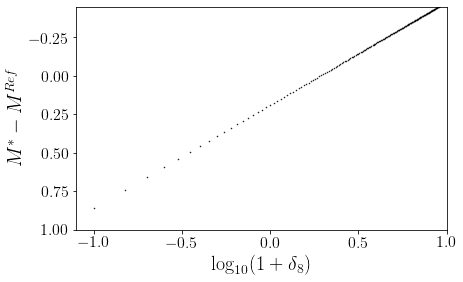

In [11]:
for d8 in np.arange(-1., 20., 0.05):
    dd, log10phistar, Mstar, alpha = schechter_d8(None, d8, params=True)
    pl.plot(dd, Mstar + 20.89, marker='.', lw=0.0, markersize=1, c='k')
    
pl.xlabel(r'$\log_{10}(1 + \delta_8)$')
pl.ylabel(r'$M^* - M^{Ref}$')

pl.xlim(-1.1,   1.0)
pl.ylim(1.0,  -0.45)

FileNotFoundError: [Errno 2] No such file or directory: '/cosma/home/durham/dc-wils7/data/GAMA4/gama_gold_G9_ddp_n8_d0_0_lumfn.fits'

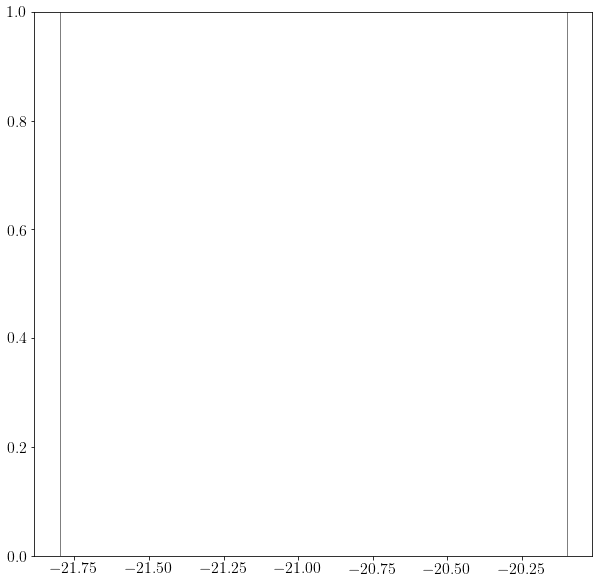

In [14]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax   = plt.subplots(1, 1, figsize=(10,10))

ax.axvline(-20.1, c='k', lw=0.5)
ax.axvline(-21.8, c='k', lw=0.5)

for i in d8_plot_idx:
    lfs   = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i) for field in fields]
    lf    = multifield_lumfn(lfs, ext='LUMFN', weight='DDP1_d{}_VOLFRAC_FIELD'.format(i))

    ddp   = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))

    refs  = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i)]
    ref   = multifield_lumfn(refs, ext='REFERENCE')

    label = ddp.meta['D8{}LIMS'.format(i)]

    ax.plot(ref['MS'], np.log10(ref['REFSCHECHTER']), label='', alpha=1, c=colors[i], linestyle='--')
    ax.plot(lf['MID_M'], np.log10(lf['PHI_IVMAX']), label=label, marker='.', lw=0.0, c=colors[i], markersize=6)

    d8    = fetch_header(ftype='ddp_n8_d0_lumfn', survey=survey, field='G9', version=version, utier=i, name='DDP1_d{}_TIERMEDd8'.format(i), debug=False)
    d8    = float(d8)
    
    ax.plot(ref['MS'], np.log10(schechter_d8(ref['MS'], d8, params=False, fit=False)), label=f'd8: {d8}', c=colors[i])

    # print(i, 'DDP1_d{}_TIERMEDd8'.format(i), d8)
    
ax.plot(ref['MS'], np.log10(named_schechter(ref['MS'], 'TMR')), linestyle='--', c='k', lw=1.)
    
ax.set_xlabel(r'$M_r^e - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

ax.set_xlim(-15.5, -23.0)
ax.set_ylim(-5.5, -0.5)

ax.legend(frameon=False, loc=3, ncol=4, fontsize=10)
ax.set_title('G9/12/15')

Retrieved relative weights: [0.34602312 0.31844002 0.33553686] for DDP1_d0_VOLFRAC_FIELD weight.
Retrieved relative weights: [0.33487309 0.31937325 0.34575365] for DDP1_d3_VOLFRAC_FIELD weight.


/tmp/ipykernel_214767/3358497665.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=0.0, c=colors[i], markersize=8, marker='.')
/tmp/ipykernel_214767/3358497665.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=0.0, c=colors[i], markersize=8, marker='.')


Retrieved relative weights: [0.34114629 0.36700488 0.29184883] for DDP1_d5_VOLFRAC_FIELD weight.
Retrieved relative weights: [0.20107981 0.37571814 0.42320205] for DDP1_d8_VOLFRAC_FIELD weight.


/tmp/ipykernel_214767/3358497665.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=0.0, c=colors[i], markersize=8, marker='.')
/tmp/ipykernel_214767/3358497665.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=0.0, c=colors[i], markersize=8, marker='.')


Text(0.5, 1.0, 'G9/12/15')

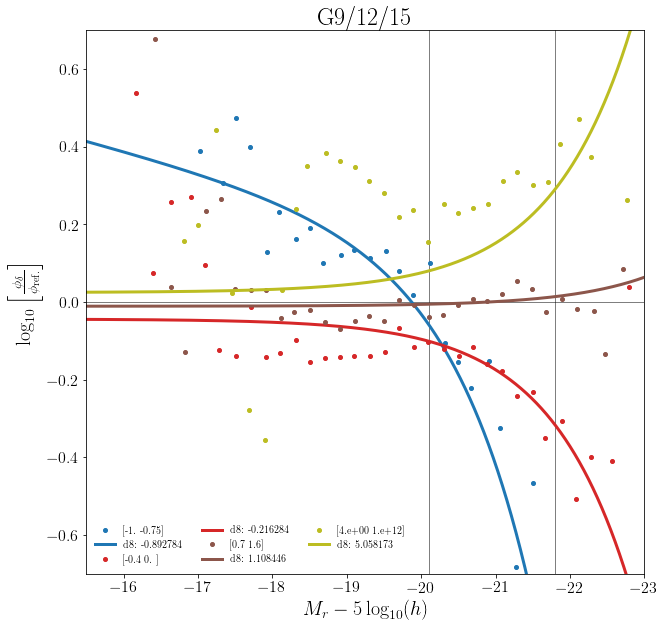

In [13]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax   = plt.subplots(1, 1, figsize=(10,10))

ax.axhline(0.0, lw=0.5, c='k')

for line in tmr_DDP1:
    ax.axvline(line, lw=0.5, c='k')

for i in d8_plot_idx:
    lfs   = [findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i) for field in fields]
    lf    = multifield_lumfn(lfs, ext='LUMFN', weight='DDP1_d{}_VOLFRAC_FIELD'.format(i), sub_cols=['MEDIAN_M', 'REF_RATIO'])

    ddp   = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))
    ref   = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

    label = ddp.meta['D8{}LIMS'.format(i)]

    ax.plot(lf['MEDIAN_M'], np.log10(lf['REF_RATIO']), label=label, lw=0.0, c=colors[i], markersize=8, marker='.')
    
    d8    = fetch_header(ftype='ddp_n8_d0_lumfn', survey=survey, field='G9', version=version, utier=i, name='DDP1_d{}_TIERMEDd8'.format(i), debug=False)
    d8    = float(d8)
    
    ax.plot(ref['MS'], np.log10(schechter_d8(ref['MS'], d8, params=False, fit=False) / ref['REFSCHECHTER']), label=f'd8: {d8}', c=colors[i])

ax.set_xlabel(r'$M_r - 5 \log_{10}(h)$')
ax.set_ylabel(r'$\log_{10} \left[ \frac{\phi_\delta}{\phi_{\rm ref.}} \right] $')

ax.set_xlim(-15.5, -23.0)
ax.set_ylim(-0.7,    0.7)

ax.legend(frameon=False, loc=3, ncol=3, fontsize=10)
ax.set_title('G9/12/15')

# Done.